# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
#import seaborn as sns

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata

In [2]:
(movies,people,list_of_genres_id) = ldata.load_dataframes();

2019-01-12 12:56:47,736 | INFO : Data loaded !


In [3]:
people.head()

cast_id            character                 credit_id  gender     id  \
0      242           Jake Sully  5602a8a7c3a3685532001c9a       2  65731   
1        3              Neytiri  52fe48009251416c750ac9cb       1   8691   
2       25  Dr. Grace Augustine  52fe48009251416c750aca39       1  10205   
3        4        Col. Quaritch  52fe48009251416c750ac9cf       2  32747   
4        5         Trudy Chacon  52fe48009251416c750ac9d3       1  17647   

   movie_id                name  order  type  
0         0     Sam Worthington      0  cast  
1         0         Zoe Saldana      1  cast  
2         0    Sigourney Weaver      2  cast  
3         0        Stephen Lang      3  cast  
4         0  Michelle Rodriguez      4  cast

In [ ]:
#Used to create a new feature matrix that contains only the actors (not the crew)
#features_actors=ldata.create_features(movies,people);

In [ ]:
#the list that makes the conversion between numerical values and genres titles
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

In [ ]:
movies.budget.plot(kind='hist', bins = 20, figsize = (5,5))
plt.title('Budget of all movies')
plt.show()

In [ ]:
data=movies['genres_names'].value_counts()
data

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(data, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(data,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

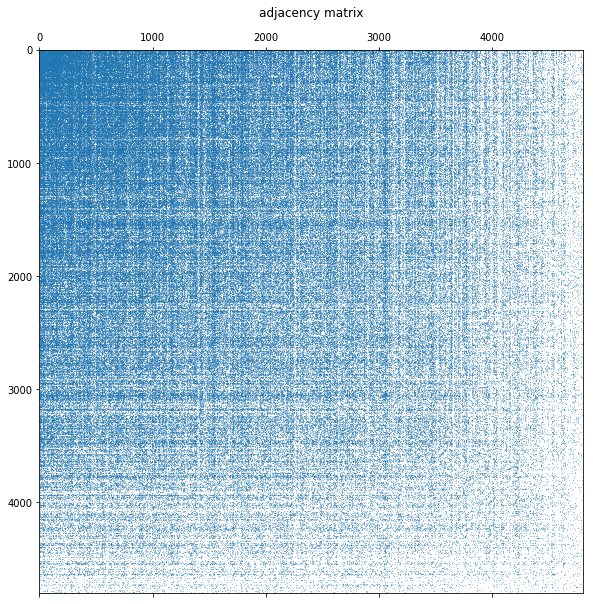

In [6]:
#CODE TO GENERATE THE ADJACENCY MATRIX THAT CONNECTES MOVIES TOGETHER
#TAKE A LONG AMOUNT OF TIME, SO JUST USE adjacency_test=np.load('./data/adjacency_test_movies.npy')

#features_movies=ldata.load_features();
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)
#np.save('./data/adjacency_actors_only', adjacency_test);
#adjacency_test

#The commented lines can be replaced by the line below --> the creation of the adjacency doesn't have to be done each time.
#adjacency_test=np.load('./data/adjacency_actors_only.npy')

#need to find a way to select only certain movies from the features ()

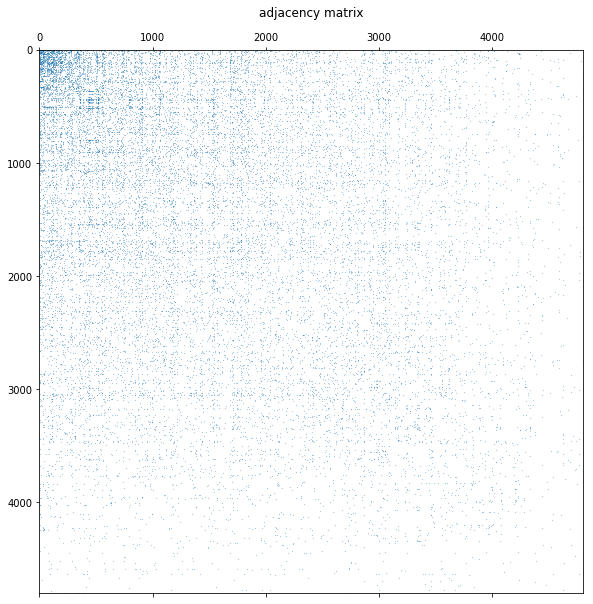

In [9]:
#adjacency using only the actors, not the crew
adjacency=np.load('./data/adjacency_actors_only.npy')
#need at least two of the same actor
adjacency[adjacency <2]=0
plt.figure(figsize=(10, 10))
plt.spy(adjacency, markersize=0.1)
plt.title('adjacency matrix')

G_test = nx.from_numpy_matrix(adjacency)
nx.number_connected_components(G_test)
Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
coords_test = nx.spring_layout(Gc_test,k=0.03)  # Force-directed layout.


C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


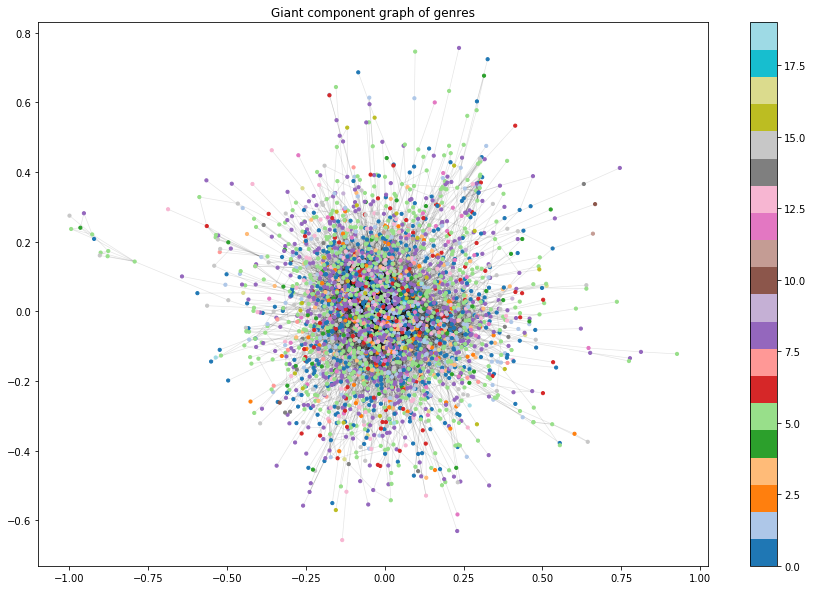

In [10]:
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='tab20')
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of genres')
plt.colorbar(im);

#action=0=bleu foncé
#comedy=8= mauve
#drama=5=vert clair

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


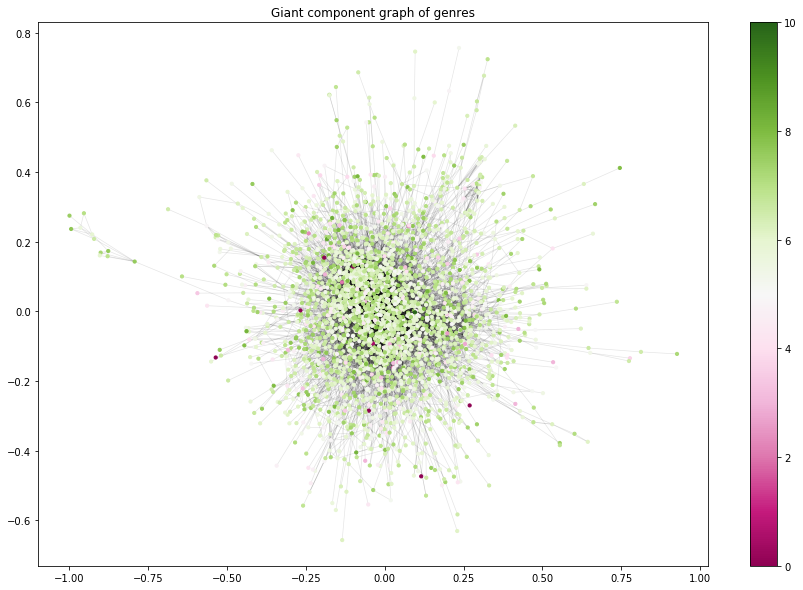

In [28]:
labels = movies['vote_average'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of genres')
plt.colorbar(im);

In [11]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

2019-01-12 13:26:27,800 | INFO : The budget max = 31115000
2019-01-12 13:26:27,802 | INFO : 862      2000000
1125    31115000
2140    20000000
2170      806948
2192    20000000
Name: budget, dtype: int64
2019-01-12 13:26:27,819 | INFO : The number of nodes is : 63


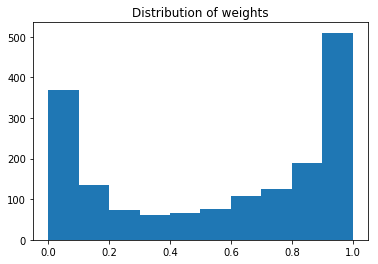

2019-01-12 13:26:27,968 | INFO : The number of edges is : 619
2019-01-12 13:26:27,969 | INFO : Adjacency done !
2019-01-12 13:26:28,007 | INFO : The budget max = 55000000
2019-01-12 13:26:28,009 | INFO : 813     55000000
1243      500000
1367    35000000
1403    35000000
1510    35000000
Name: budget, dtype: int64
2019-01-12 13:26:28,024 | INFO : The number of nodes is : 89


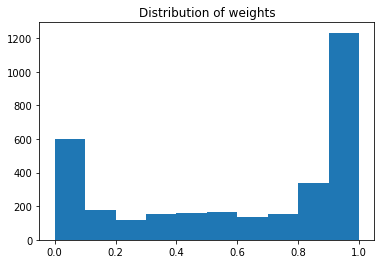

2019-01-12 13:26:28,181 | INFO : The number of edges is : 1444
2019-01-12 13:26:28,183 | INFO : Adjacency done !
2019-01-12 13:26:28,204 | INFO : The budget max = 70000000
2019-01-12 13:26:28,208 | INFO : 379    20000000
417     8000000
587    70000000
655     4200000
794    63000000
Name: budget, dtype: int64
2019-01-12 13:26:28,224 | INFO : The number of nodes is : 232


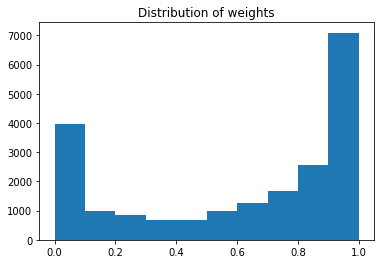

2019-01-12 13:26:28,385 | INFO : The number of edges is : 8570
2019-01-12 13:26:28,385 | INFO : Adjacency done !
2019-01-12 13:26:28,421 | INFO : The budget max = 200000000
2019-01-12 13:26:28,424 | INFO : 25     200000000
70     170000000
75     175000000
149    140000000
164    140000000
Name: budget, dtype: int64
2019-01-12 13:26:28,441 | INFO : The number of nodes is : 622


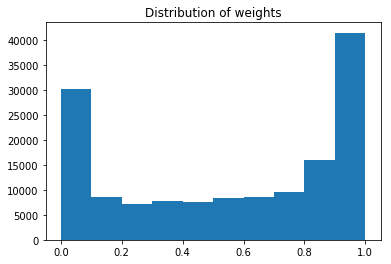

2019-01-12 13:26:28,645 | INFO : The number of edges is : 50384
2019-01-12 13:26:28,646 | INFO : Adjacency done !
2019-01-12 13:26:28,828 | INFO : The budget max = 300000000
2019-01-12 13:26:28,830 | INFO : 0     237000000
1     300000000
5     258000000
8     250000000
10    270000000
Name: budget, dtype: int64
2019-01-12 13:26:28,862 | INFO : The number of nodes is : 1554


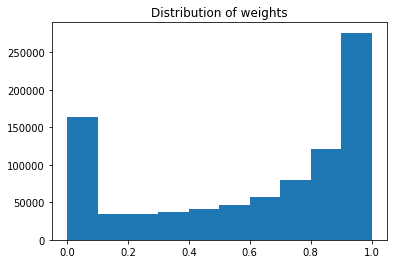

2019-01-12 13:26:29,122 | INFO : The number of edges is : 342932
2019-01-12 13:26:29,123 | INFO : Adjacency done !
2019-01-12 13:26:30,695 | INFO : The budget max = 380000000
2019-01-12 13:26:30,696 | INFO : 2    245000000
3    250000000
4    260000000
6    260000000
7    280000000
Name: budget, dtype: int64
2019-01-12 13:26:30,715 | INFO : The number of nodes is : 1139


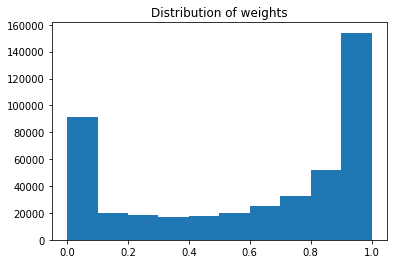

2019-01-12 13:26:31,082 | INFO : The number of edges is : 182874
2019-01-12 13:26:31,083 | INFO : Adjacency done !


In [12]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [13]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

In [14]:
#find the correlation between parameters?
#for i in range(len(graphsFilteredByYears)):
    #plt.figure(figsize=(15, 15))
    #data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity']]
    #sns.heatmap(data=data.corr(),annot=True)

In [15]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    
    i = i+1

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


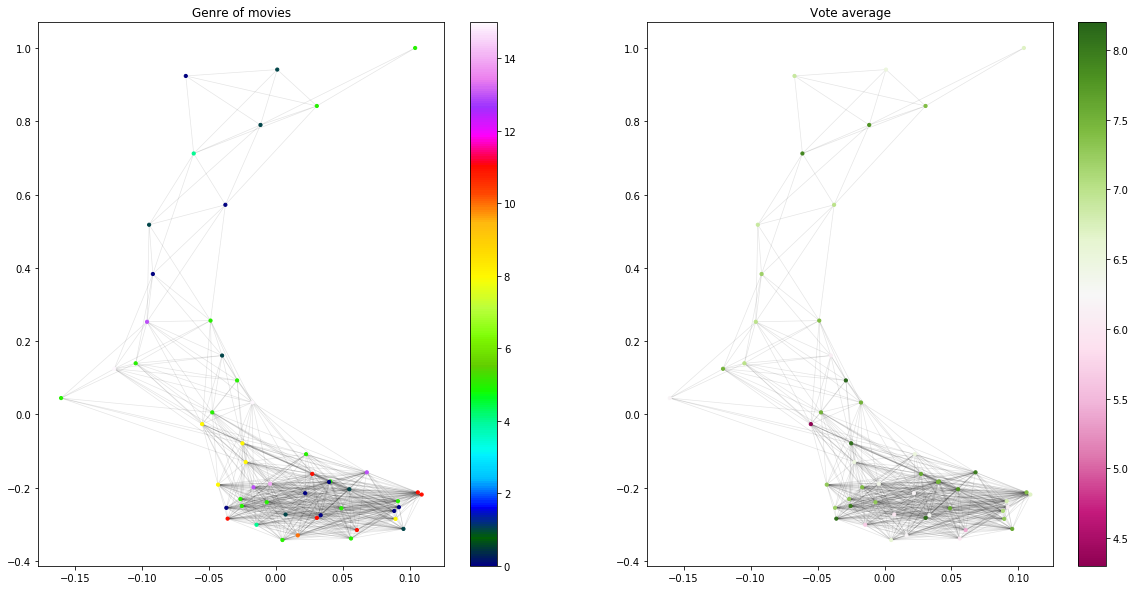

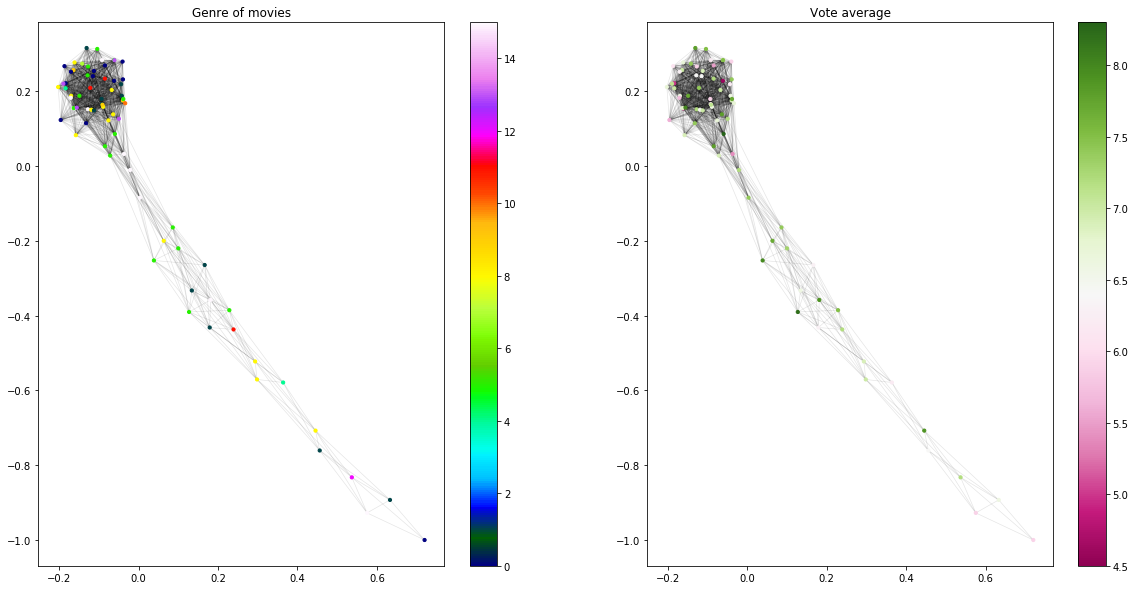

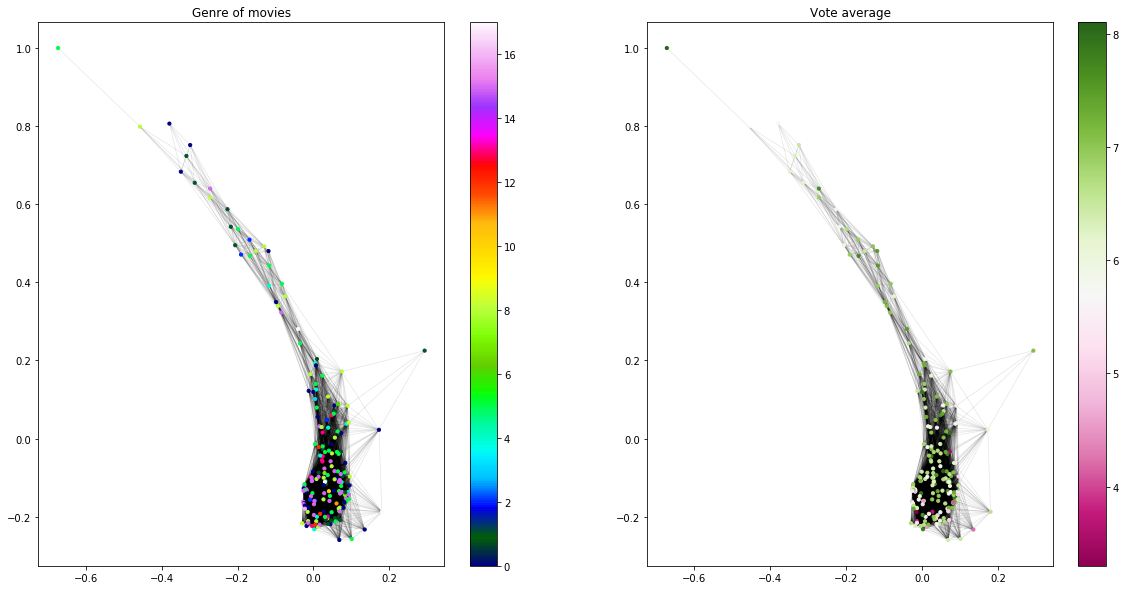

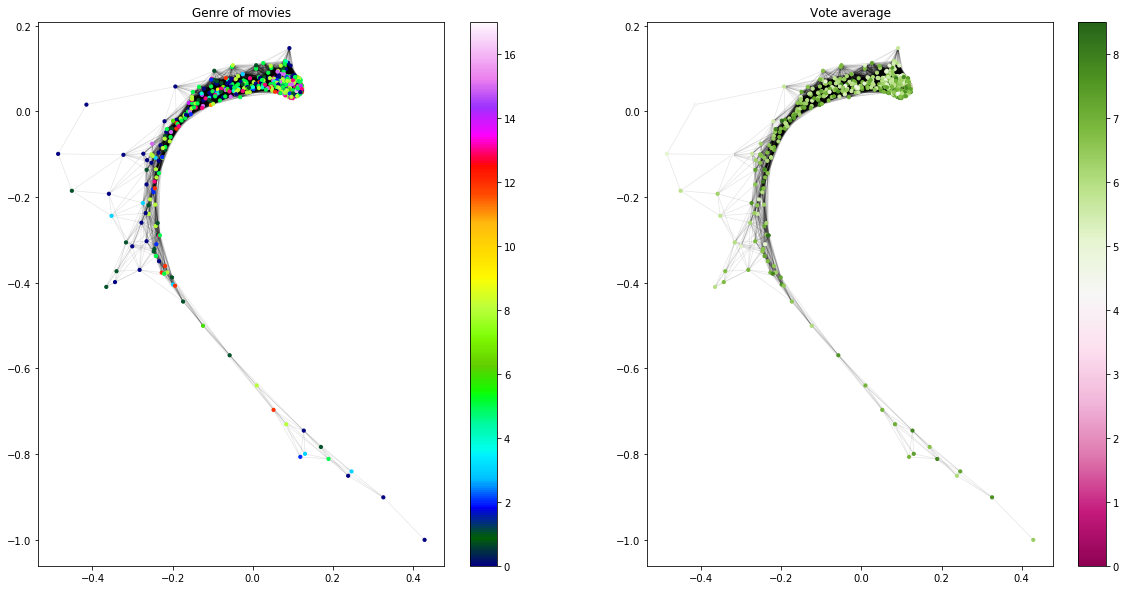

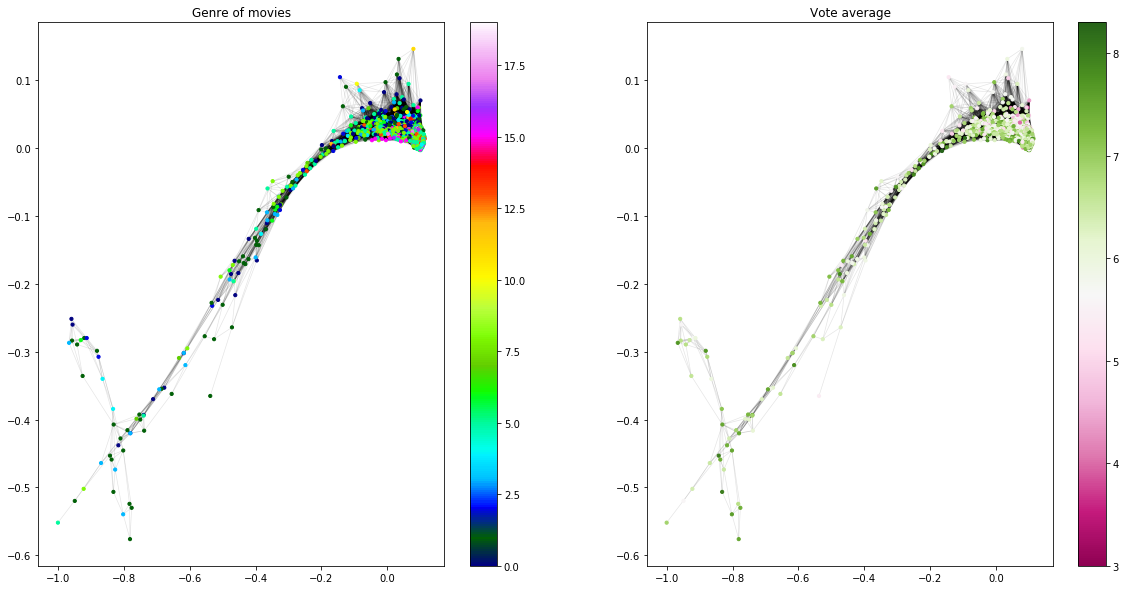

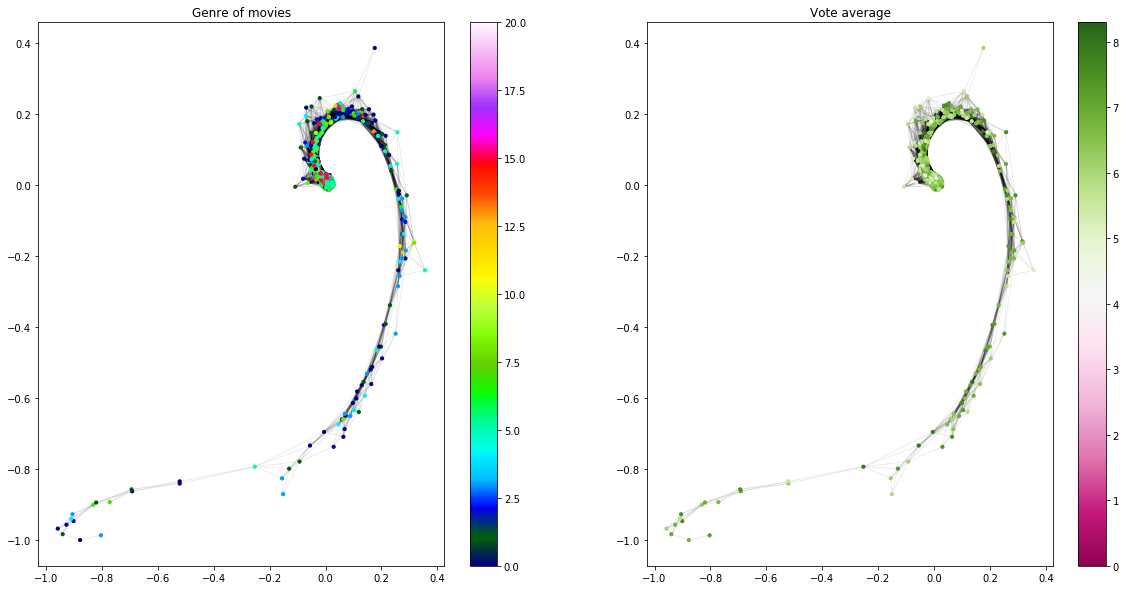

In [16]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='gist_ncar')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = voteAvrgFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1
    

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


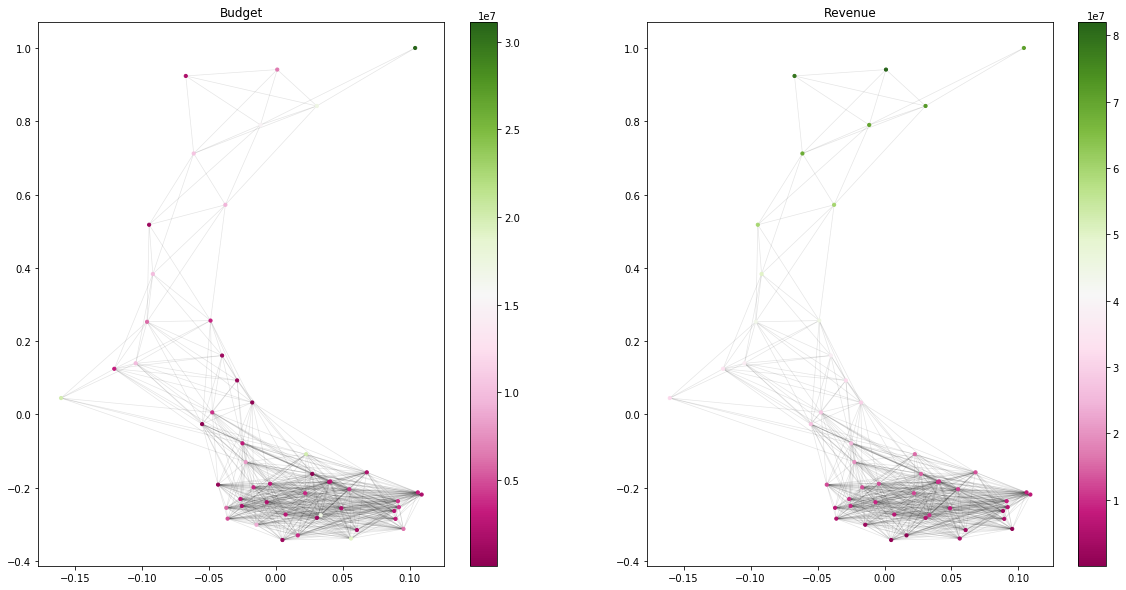

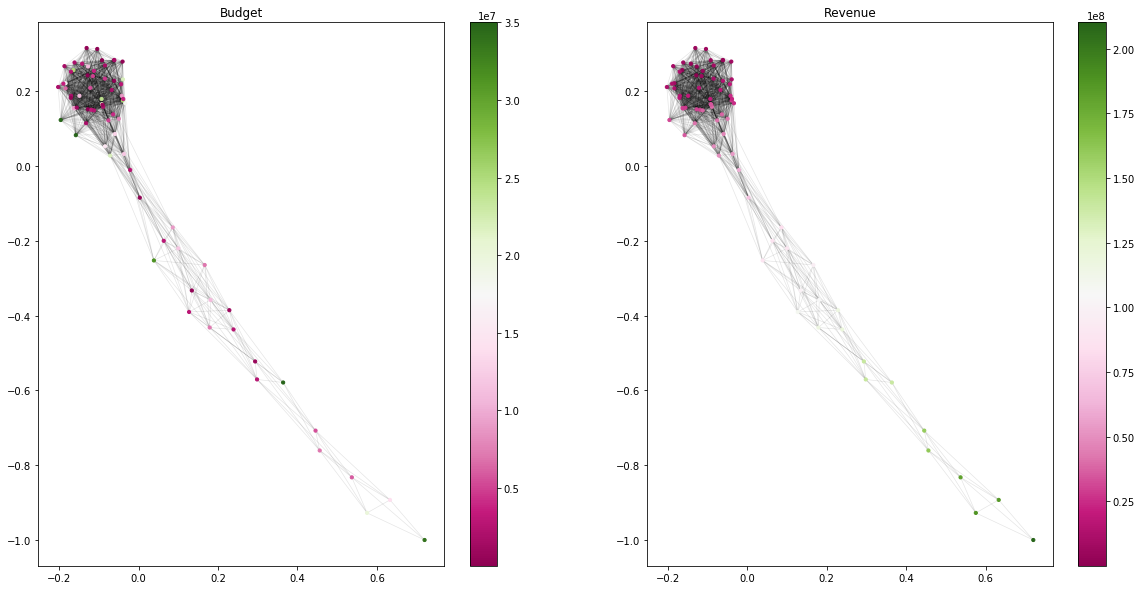

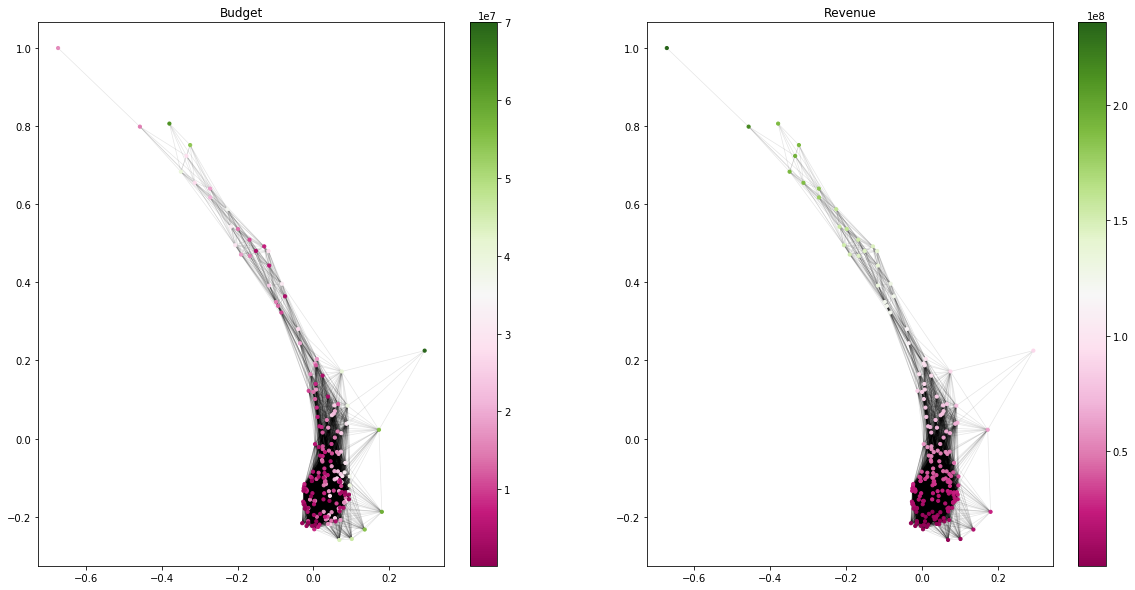

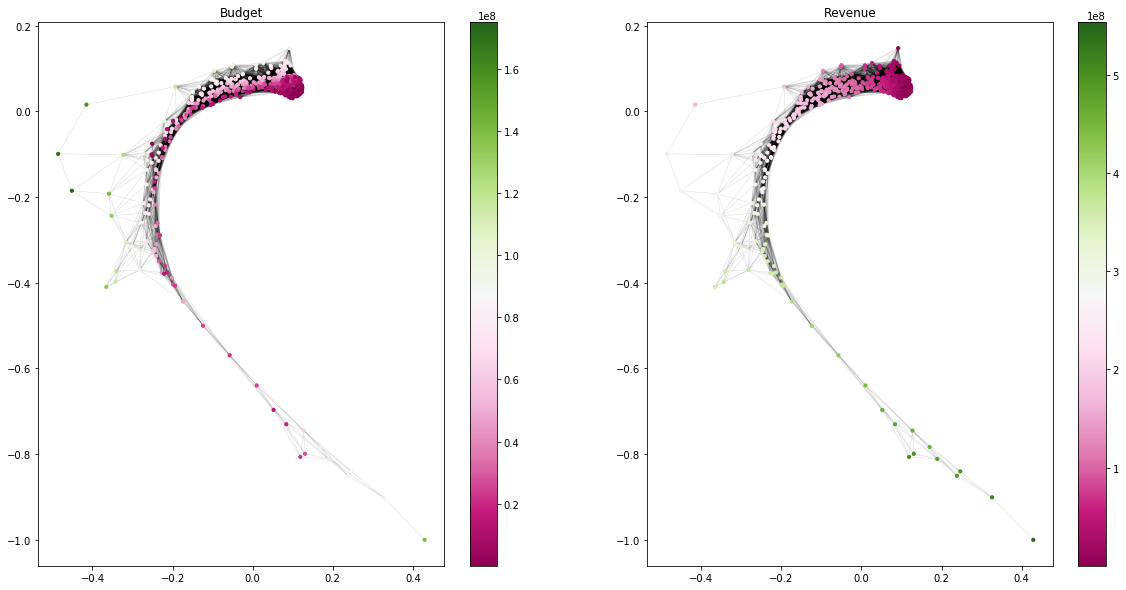

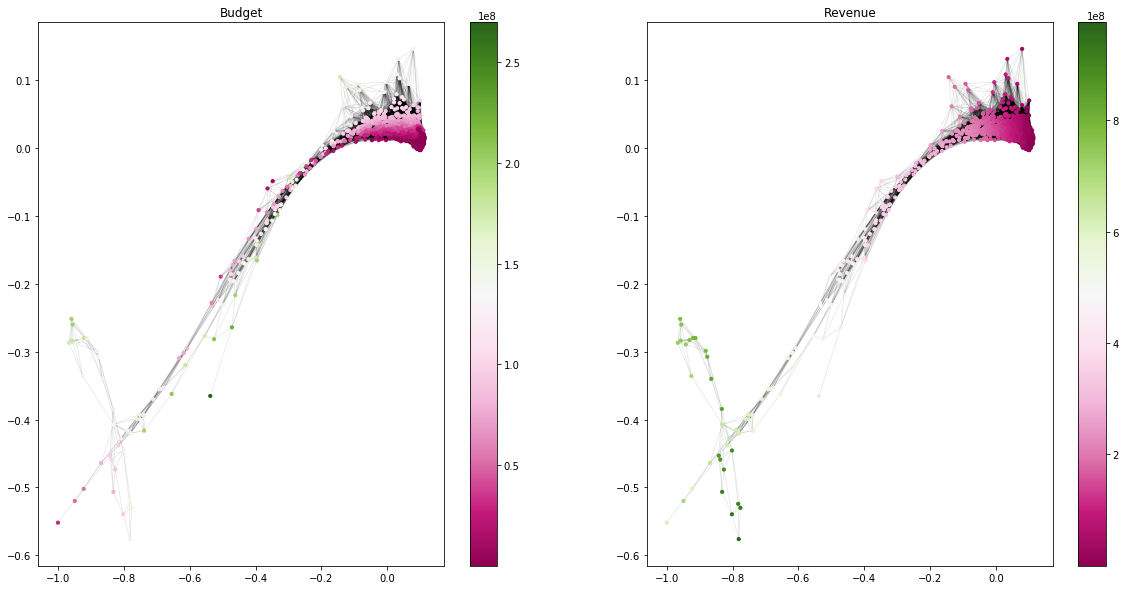

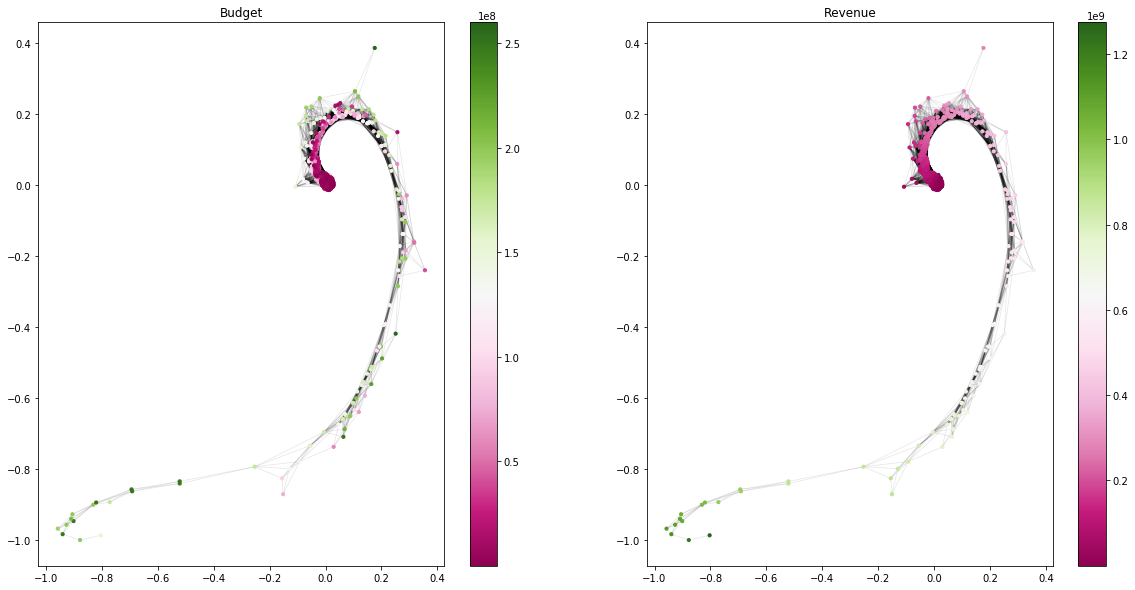

In [17]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

C:\Users\lekil\Miniconda3\envs\Week_4\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


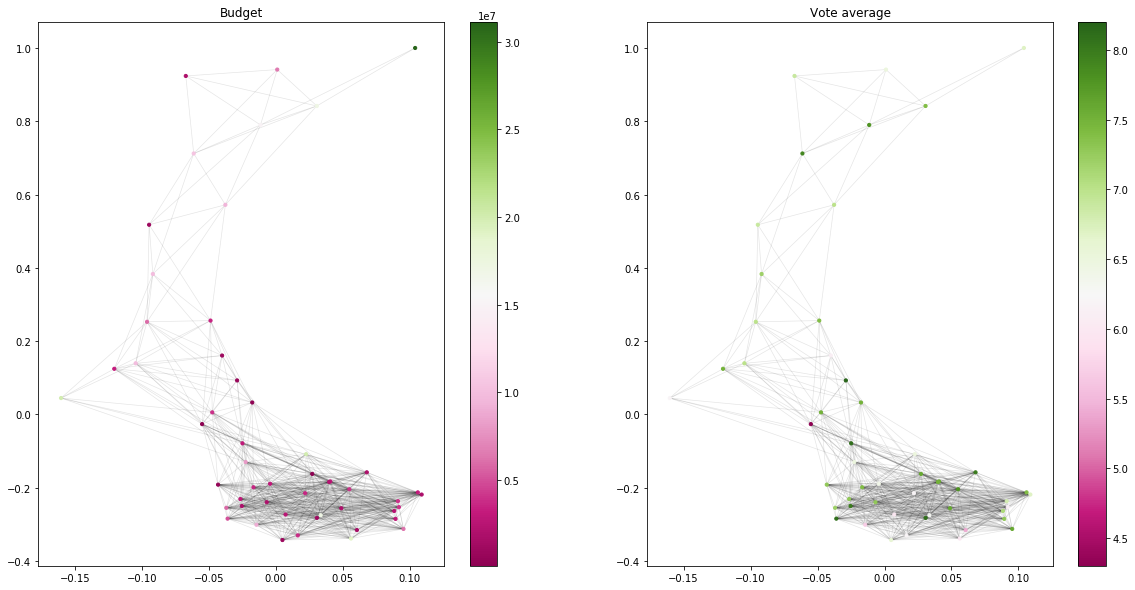

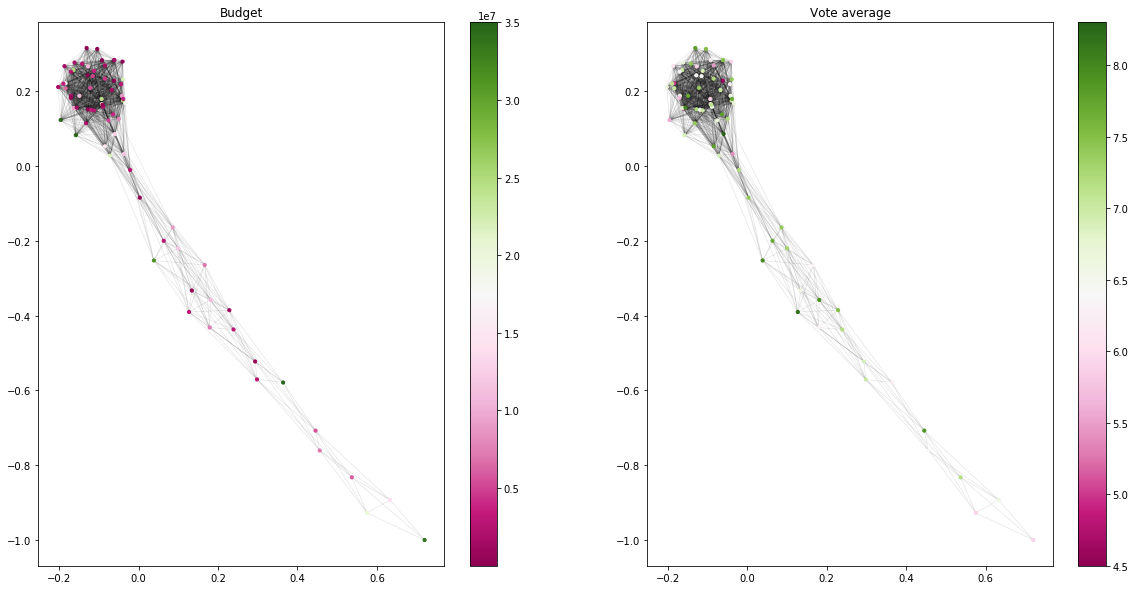

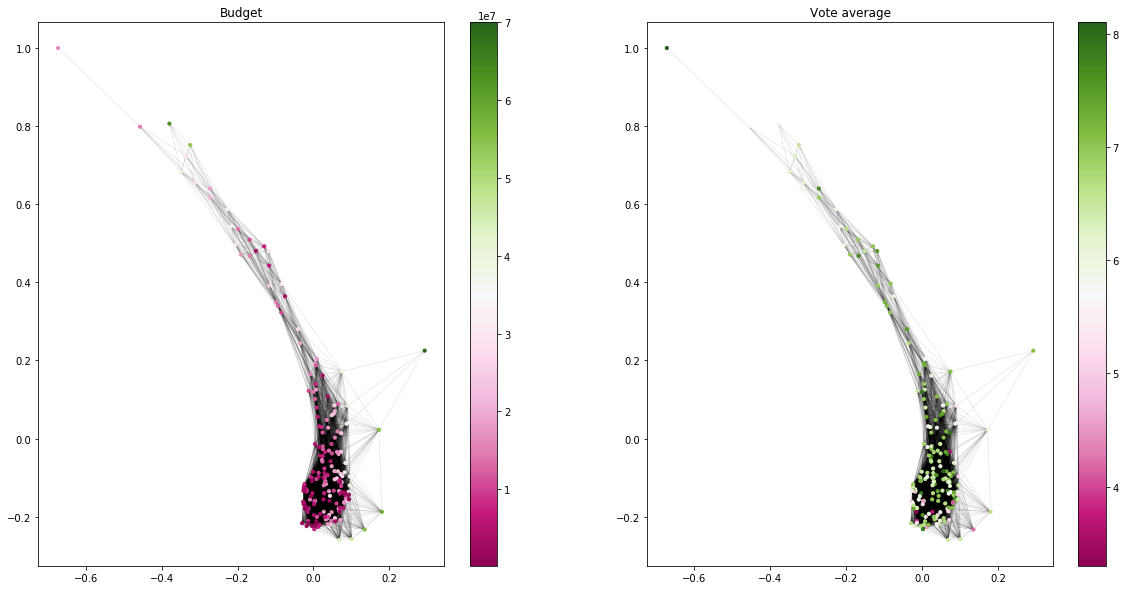

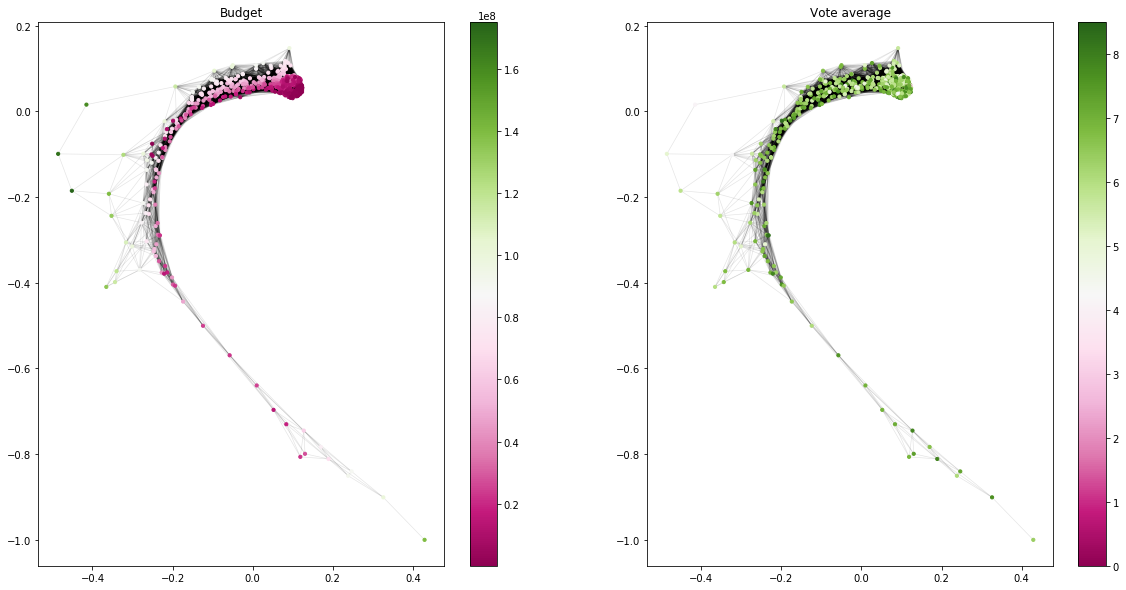

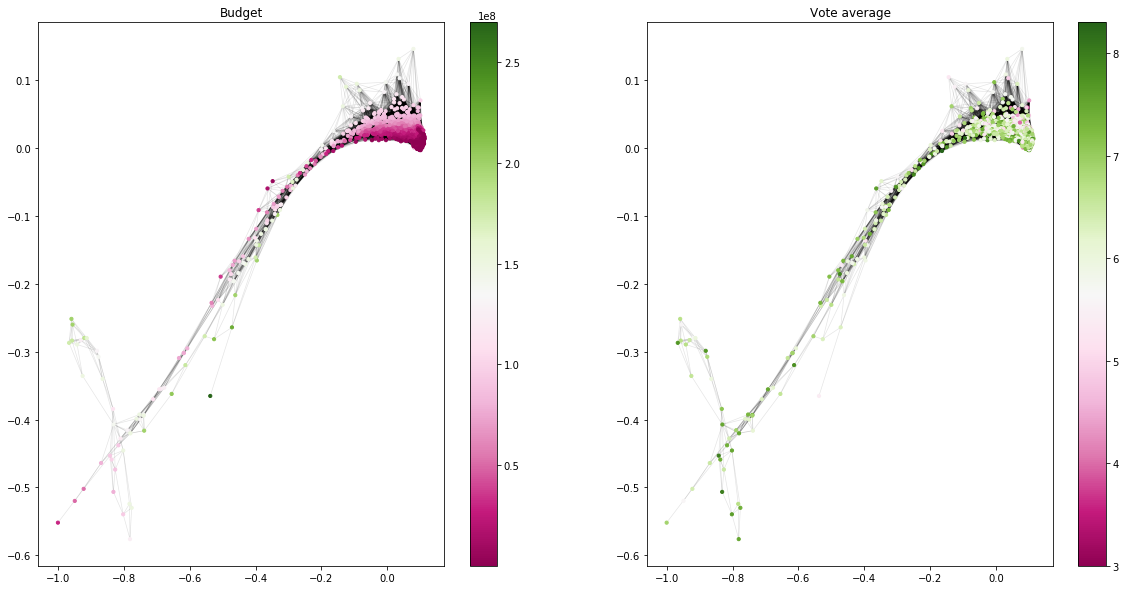

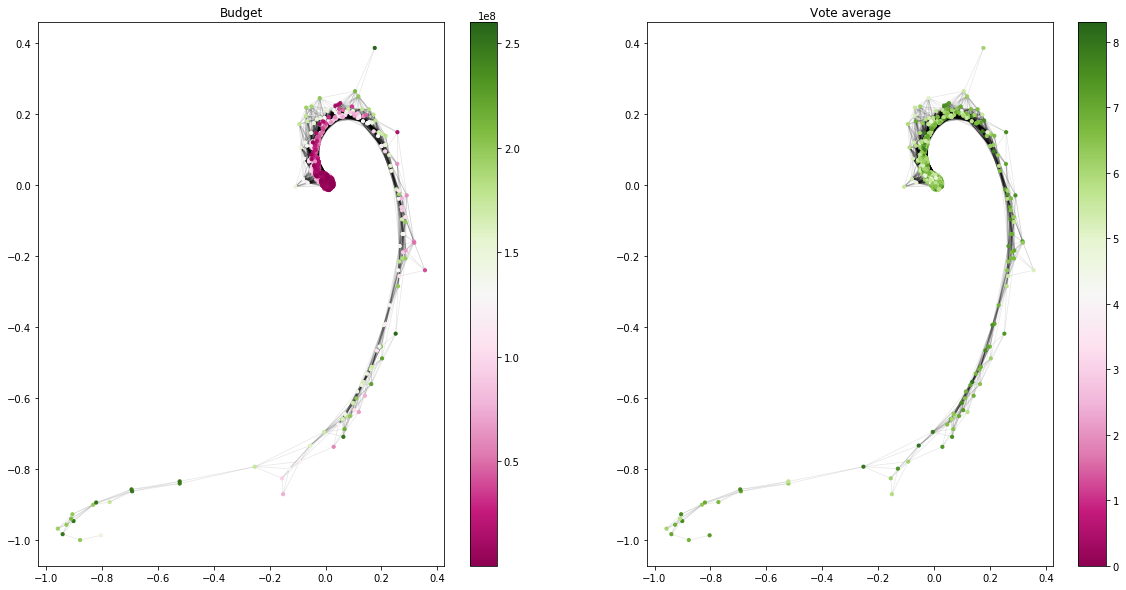

In [18]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

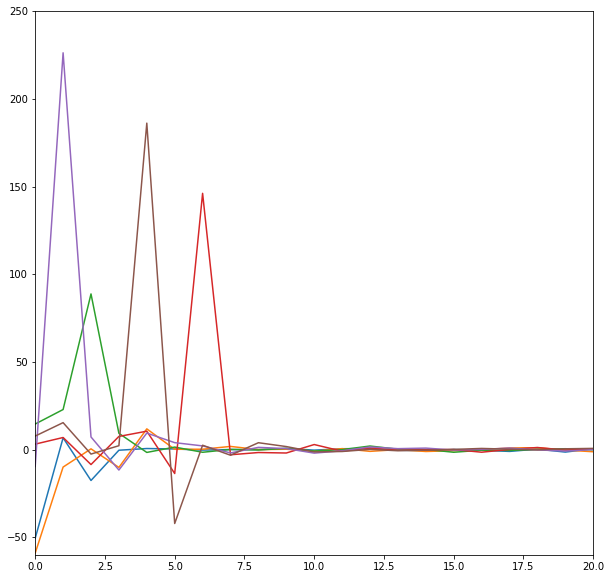

In [19]:
i=0
plt.figure(figsize=(10,10))
plt.axis([0,20,-60,250])
for G in graphsFilteredByYears:
    plt.plot(voteAvrgFtFilteredByYears[i])
    i=i+1


Text(0.5, 1.05, 'adjacency matrix')

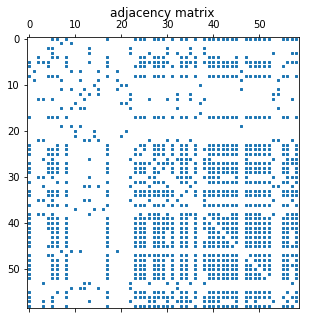

In [20]:
plt.figure(figsize=(5, 5))
plt.spy(adjacenciesFilteredByYears[0], markersize=2)
plt.title('adjacency matrix')